##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .csv file inside that. A relative path *must* be used when loading data into pandas

In [36]:
# Can have as many cells as you want for code

#general imports 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.pipeline import Pipeline
import jenkspy

#ML functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import classification_report


#ML models 
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv("catA_train.csv")
# Deleting unnecessary columns



In [20]:
df = df.drop(['LATITUDE', 'LONGITUDE', 'AccountID', 'SIC Code', 'Company', 
              '8-Digit SIC Code',  '8-Digit SIC Description', 
              'Company Description', 'Square Footage', 'Import/Export Status', 
              'Fiscal Year End', 'Global Ultimate Company', 
              'Domestic Ultimate Company', 'Company Status (Active/Inactive)', 'Parent Company'], axis=1)

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [21]:
#Processing functions
def fill_na_with_mean(dataframe, column_name):
    mean_value = dataframe[column_name].mean()
    dataframe[column_name].fillna(mean_value, inplace=True)
    return dataframe

def assign_numbers_to_unique_strings(dataframe, column_name):
    # Create a unique number for each unique string
    unique_strings = dataframe[column_name].unique()
    string_to_number = {string: i for i, string in enumerate(unique_strings)}
    
    # Map the strings to numbers and create a new column
    dataframe[column_name + '_Numbered'] = dataframe[column_name].map(string_to_number)
    return dataframe

def assign_binary_to_na(dataframe, column_name):
    # Assign 1 to non-NA values and 0 to NA values in the specified column
    dataframe[column_name + '_Binary_NA'] = dataframe[column_name].notna().astype(int)
    return dataframe


#Process Data
def preprocessing(df):
    num_to_string_holder = ["Entity Type", "Ownership Type"]
    drop_na_holder = ["Employees (Domestic Ultimate Total)", "Parent Country"]
    fill_na_with_mean_holder = ["Year Found", "Employees (Single Site)", "Employees (Global Ultimate Total)"]
    
    
    pd.set_option('display.float_format', '{:.2f}'.format)
    
    
    for i in drop_na_holder:
        df = df.dropna(subset=[i])
    
    for i in fill_na_with_mean_holder:
        if i == "Year Found":
            df = fill_na_with_mean(df, i)
            df['Age'] = 2024 - df[i]
            df = df.drop(i, axis=1)
        else: 
            df = fill_na_with_mean(df, i)
            df = df.drop(i, axis=1)

    industry_counts = df['Industry'].value_counts()
    industries_to_keep = industry_counts[industry_counts >= 8].index
    df = df[df['Industry'].isin(industries_to_keep)]

    
    dummy_holder = ["Industry", "Entity Type", "Ownership Type"]
    
    for i in dummy_holder:
        df[i] = df[i].astype("category")
        df = pd.get_dummies(df, columns=[i])
    
    country_holder = ['Global Ultimate Country', 'Parent Country']
    
    for i in country_holder:
        country_counts = df[i].value_counts()
        countries_to_keep = country_counts[country_counts >= 5].index
        df = df[df[i].isin(countries_to_keep)]
        df[i] = df[i].astype("category")
        df = pd.get_dummies(df, columns=[i])  
        
    # log transforming values
    df = df[df['Sales (Domestic Ultimate Total USD)'] >= 0]
    #df = df[df['Sales (Domestic Ultimate Total USD)'] >= 3000]
    df['Log_Sales'] = np.log1p(df['Sales (Domestic Ultimate Total USD)'])
    
    
    Q1 = df['Log_Sales'].quantile(0.25)
    Q3 = df['Log_Sales'].quantile(0.75)
    IQR = Q3 - Q1
    #identify outliers
    outliers = ((df['Log_Sales'] < (Q1 - 1.7 * IQR)) | (df['Log_Sales'] > (Q3 + 1.7 * IQR)))
    #drop outliers
    df = df[~outliers]

    return df

pd.set_option('display.max_columns', None)
df = preprocessing(df)

In [22]:
df

,Employees (Domestic Ultimate Total),Sales (Domestic Ultimate Total USD),Sales (Global Ultimate Total USD),Is Domestic Ultimate,Is Global Ultimate,Age,Industry_Accident and Health Insurance,"Industry_Accounting, Auditing, and Bookkeeping Services",Industry_Advertising Agencies,"Industry_Advertising, Not Elsewhere Classified","Industry_Air Transportation, Nonscheduled","Industry_Air Transportation, Scheduled","Industry_Aircraft Parts and Auxiliary Equipment, Not Elsewhere Classified","Industry_Airports, Flying Fields, and Airport Terminal Services","Industry_Amusement and Recreation Services, Not Elsewhere Classified",Industry_Architectural Services,"Industry_Arrangement of Passenger Transportation, Not Elsewhere Classified",Industry_Arrangement of Transportation of Freight and Cargo,Industry_Auto and Home Supply Stores,Industry_Automobiles and Other Motor Vehicles,"Industry_Automotive Repair Shops, Not Elsewhere Classified","Industry_Automotive Services, Except Repair and Carwashes",Industry_Beauty Shops,"Industry_Biological Products, Except Diagnostic Substances",Industry_Book Printing,"Industry_Books Publishing, or Publishing and Printing","Industry_Books, Periodicals, and Newspapers",Industry_Bottled and Canned Soft Drinks and Carbonated Waters,"Industry_Bread and Other Bakery Products, Except Cookies and Crackers","Industry_Brick, Stone, and Related Construction Materials","Industry_Bridge, Tunnel, and Elevated Highway Construction","Industry_Building Cleaning and Maintenance Services, Not Elsewhere Classified",Industry_Business Associations,"Industry_Business Consulting Services, Not Elsewhere Classified","Industry_Business Services, Not Elsewhere Classified",Industry_Business and Secretarial Schools,Industry_Cable and Other Pay Television Services,Industry_Catalog and Mail-order Houses,"Industry_Cement, Hydraulic",Industry_Cemetery Subdividers and Developers,"Industry_Chemicals and Allied Products, Not Elsewhere Classified","Industry_Chemicals and Chemical Preparations, Not Elsewhere Classified",Industry_Child Day Care Services,"Industry_Civic, Social, and Fraternal Associations",Industry_Coal and Other Minerals and Ores,"Industry_Coating, Engraving, and Allied Services, Not Elsewhere Classified","Industry_Colleges, Universities, and Professional Schools",Industry_Commercial Art and Graphic Design,"Industry_Commercial Banks, Not Elsewhere Classified","Industry_Commercial Economic, Sociological, and Educational Research","Industry_Commercial Equipment, Not Elsewhere Classified",Industry_Commercial Physical and Biological Research,"Industry_Commercial Printing, Not Elsewhere Classified",Industry_Commodity Contracts Brokers and Dealers,"Industry_Communications Equipment, Not Elsewhere Classified","Industry_Communications Services, Not Elsewhere Classified",Industry_Computer Facilities Management Services,Industry_Computer Integrated Systems Design,Industry_Computer Maintenance and Repair,"Industry_Computer Peripheral Equipment, Not Elsewhere Classified",Industry_Computer Processing and Data Preparation and Processing Services,Industry_Computer Programming Services,"Industry_Computer Related Services, Not Elsewhere Classified",Industry_Computer Rental and Leasing,Industry_Computer Storage Devices,Industry_Computer and Computer Software Stores,Industry_Computers and Computer Peripheral Equipment and Software,"Industry_Concrete Products, Except Block and Brick",Industry_Confectionery,Industry_Construction Machinery and Equipment,"Industry_Construction Materials, Not Elsewhere Classified",Industry_Construction and Mining (Except Petroleum) Machinery and Equipment,"Industry_Converted Paper and Paperboard Products, Not Elsewhere Classified",Industry_Conveyors and Conveying Equipment,Industry_Crude Petroleum and Natural Gas,"Industry_Cutting Tools, Machine Tool Accessories, and Machinists' Precision Measuring Devices","Industry_Dairy Products, Except Dried or Canned",Industry_Department Stores,"Industry_Detective, Guard, and Armor

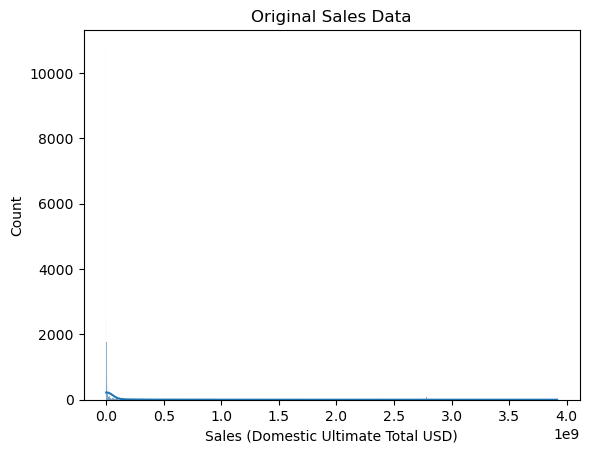

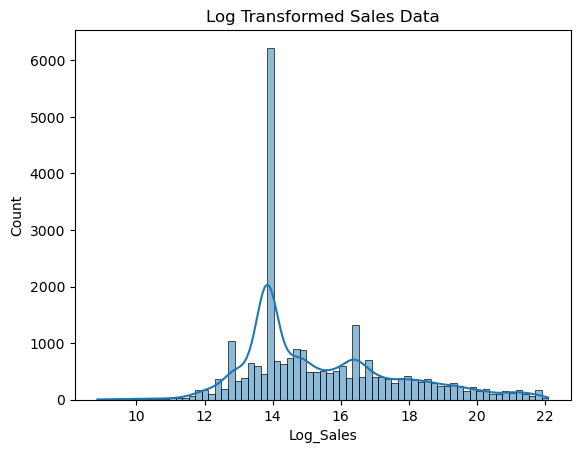

In [75]:
#show distribution before and after transformation

# sns.histplot(df['Sales (Domestic Ultimate Total USD)'], kde=True)
# plt.title("Original Sales Data")
# plt.show()

# # # After transformation
# sns.histplot(df['Log_Sales'], kde=True)
# plt.title("Log Transformed Sales Data")
# plt.show()


In [23]:

# Apply Jenks Natural Breaks Optimization on Log_Sales
log_sales_data = df['Log_Sales'].values
breaks = jenkspy.jenks_breaks(log_sales_data, 5)  

print(breaks)

def categorize_log_sales(sales, breaks):
    for i in range(len(breaks) - 1):
        if sales <= breaks[i + 1]:
            return f'Segment_{i}'
    return f'Segment_{len(breaks) - 1}'

df['Log_Sales_Segment'] = df['Log_Sales'].apply(lambda x: categorize_log_sales(x, breaks))


[8.853808274977197, 13.300384031896577, 15.107041664688868, 17.163826050757237, 19.306899587138634, 22.08857081890361]


In [24]:
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor  # Example model
from sklearn.metrics import mean_squared_error, mean_absolute_error

print(df['Log_Sales_Segment'].value_counts())

segments = df['Log_Sales_Segment'].unique()
models = {}
mse_scores = {}
mae_scores = {}
r2_scores = {}
adjusted_r2_scores = {}
r2_train_scores = {}

for segment in segments:
    segment_df = df[df['Log_Sales_Segment'] == segment]
    
    X = segment_df.drop(['Sales (Domestic Ultimate Total USD)', 'Log_Sales', 'Log_Sales_Segment'], axis=1)
    y = segment_df['Log_Sales']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    n_features = X_train.shape[1]  # Number of features
    print(n_features)
    n_obs = len(y_train) 
    
    print(n_obs)
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    train_pred_log = model.predict(X_train)
    log_pred = model.predict(X_test)
    
    # Inverse transform the predictions
    train_pred = np.expm1(train_pred_log)
    pred = np.expm1(log_pred)
    
    # Calculate MSE, MAE, and R-squared using the original sales values
    original_y_test = np.expm1(y_test)
    mae = mean_absolute_error(original_y_test, pred)
    r2 = r2_score(original_y_test, pred)
    
    r2_train = r2_score(y_train, train_pred_log)


    # Calculate Adjusted R-squared
    adjusted_r2 = 1 - (1 - r2) * (n_obs - 1) / (n_obs - n_features - 1)

    models[segment] = model
    mae_scores[segment] = mae
    r2_scores[segment] = r2
    adjusted_r2_scores[segment] = adjusted_r2
    r2_train_scores[segment] = r2_train
    
    print(f"Segment: {segment}, MAE: {mae}, R-squared: {r2}, Adjusted R-squared: {adjusted_r2}, R-squared-training: {r2_train}" )

Segment_1    11924
Segment_2     6122
Segment_3     3654
Segment_0     3096
Segment_4     2055
Name: Log_Sales_Segment, dtype: int64
416
9539
Segment: Segment_1, MAE: 111187.14011907141, R-squared: 0.7902468791802274, Adjusted R-squared: 0.7806812906841711, R-squared-training: 0.9736201158839705
416
2476
Segment: Segment_0, MAE: 29283.957990107458, R-squared: 0.6955821631484089, Adjusted R-squared: 0.6340776366159845, R-squared-training: 0.9378927991898127
416
1644
Segment: Segment_4, MAE: 153783045.00398484, R-squared: 0.7628890118093623, Adjusted R-squared: 0.682499304321746, R-squared-training: 0.9677208601541709
416
4897
Segment: Segment_2, MAE: 1902102.4493294728, R-squared: 0.6274177394118577, Adjusted R-squared: 0.5928208152143875, R-squared-training: 0.9476379862474301
416
2923
Segment: Segment_3, MAE: 16175078.05864212, R-squared: 0.6175877674289307, Adjusted R-squared: 0.5541067264275081, R-squared-training: 0.9513297510266866


In [25]:
Xs = df.drop(['Log_Sales_Segment', 'Log_Sales', 'Sales (Domestic Ultimate Total USD)'], axis=1)
ys = df['Log_Sales_Segment']
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)
model_s = RandomForestClassifier()
model_s.fit(Xs_train, ys_train)
ys_pred = model_s.predict(Xs_test)
print(classification_report(ys_test, ys_pred))
print('Accuracy:', accuracy_score(ys_test, ys_pred))
ys_pred


              precision    recall  f1-score   support

   Segment_0       0.93      0.83      0.87       622
   Segment_1       0.89      0.93      0.91      2316
   Segment_2       0.76      0.84      0.79      1267
   Segment_3       0.82      0.72      0.77       749
   Segment_4       0.92      0.76      0.83       417

    accuracy                           0.85      5371
   macro avg       0.86      0.81      0.84      5371
weighted avg       0.86      0.85      0.85      5371

Accuracy: 0.8521690560417055


array(['Segment_1', 'Segment_1', 'Segment_2', ..., 'Segment_3',
       'Segment_0', 'Segment_1'], dtype=object)

In [26]:
def superModel(data):
    data = data.drop(['Log_Sales_Segment', 'Log_Sales', 'Sales (Domestic Ultimate Total USD)'], axis=1)
    
    pred_segments = model_s.predict(data)
    myDic = {}
    counter = 0
    
    for i in pred_segments:
        model = models[i]
        pred = model.predict(data.iloc[[counter]])
        myDic[counter] = np.expm1(pred)
        counter += 1
    return myDic
df1 = df
pred_rat = superModel(df1.iloc[0:25000, :])

In [31]:
pred_rat.values()

dict_values([array([1842816.63574818]), array([1082131.87000798]), array([433893.91076103]), array([1026308.00000013]), array([1686714.38148155]), array([3.42441e+08]), array([9372587.70881783]), array([1026308.00000013]), array([635649.00000002]), array([6062724.19343907]), array([18630495.54937357]), array([89954450.56449439]), array([441376.]), array([6.30866949e+08]), array([10848273.29912948]), array([18443540.0000001]), array([2445248.52329989]), array([33981822.15379881]), array([1026308.00000013]), array([1026308.00000013]), array([521364.00000001]), array([1.31775071e+08]), array([384984.99999999]), array([331020.2440692]), array([9653530.88118422]), array([1026308.00000013]), array([1026308.00000013]), array([2565770.00000008]), array([1026308.00000013]), array([1026308.00000013]), array([24103262.90842455]), array([583803.97365713]), array([7697322.39976042]), array([1026308.00000013]), array([1026308.00000013]), array([10988552.3986114]), array([1.179314e+09]), array([79885

In [29]:
pred_rat[0]

array([1842816.63574818])

In [32]:
hilder = []
for i in pred_rat.values():
    hilder.append(i[0])

In [33]:
hilder

[1842816.6357481831,
 1082131.8700079815,
 433893.9107610348,
 1026308.0000001342,
 1686714.3814815462,
 342441000.00000775,
 9372587.708817834,
 1026308.0000001342,
 635649.0000000153,
 6062724.193439069,
 18630495.549373575,
 89954450.56449439,
 441375.99999999814,
 630866948.9999887,
 10848273.299129484,
 18443540.000000097,
 2445248.523299888,
 33981822.15379881,
 1026308.0000001342,
 1026308.0000001342,
 521364.0000000062,
 131775071.12079278,
 384984.99999999185,
 331020.2440692032,
 9653530.881184217,
 1026308.0000001342,
 1026308.0000001342,
 2565770.0000000778,
 1026308.0000001342,
 1026308.0000001342,
 24103262.908424553,
 583803.9736571301,
 7697322.39976042,
 1026308.0000001342,
 1026308.0000001342,
 10988552.398611402,
 1179313999.9999897,
 7988550.490841241,
 1165203.0485078664,
 1026308.0000001342,
 381784.0000000099,
 147814.99999999543,
 254188288.00001085,
 1026308.0000001342,
 13076800.000000857,
 75837055.03561768,
 94758713.00000454,
 1026308.0000001342,
 1026308.0

In [10]:
pred_rat

{0: array([1842816.63574818]),
 1: array([1082131.87000798]),
 2: array([433893.91076103]),
 3: array([1026308.00000013]),
 4: array([1686714.38148155]),
 5: array([3.42441e+08]),
 6: array([9372587.70881783]),
 7: array([1026308.00000013]),
 8: array([635649.00000002]),
 9: array([6062724.19343907]),
 10: array([18630495.54937357]),
 11: array([89954450.56449439]),
 12: array([441376.]),
 13: array([6.30866949e+08]),
 14: array([10848273.29912948]),
 15: array([18443540.0000001]),
 16: array([2445248.52329989]),
 17: array([33981822.15379881]),
 18: array([1026308.00000013]),
 19: array([1026308.00000013]),
 20: array([521364.00000001]),
 21: array([1.31775071e+08]),
 22: array([384984.99999999]),
 23: array([331020.2440692]),
 24: array([9653530.88118422]),
 25: array([1026308.00000013]),
 26: array([1026308.00000013]),
 27: array([2565770.00000008]),
 28: array([1026308.00000013]),
 29: array([1026308.00000013]),
 30: array([24103262.90842455]),
 31: array([583803.97365713]),
 32: a

In [18]:
pred_rat[0][0]

1842816.6357481831

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [37]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    
    
    result = []

    
    
    df = hidden_data.drop(['LATITUDE', 'LONGITUDE', 'AccountID', 'SIC Code', 'Company', 
              '8-Digit SIC Code',  '8-Digit SIC Description', 
              'Company Description', 'Square Footage', 'Import/Export Status', 
              'Fiscal Year End', 'Global Ultimate Company', 
              'Domestic Ultimate Company', 'Company Status (Active/Inactive)', 'Parent Company'], axis=1)
    
        #Processing functions
    def fill_na_with_mean(dataframe, column_name):
        mean_value = dataframe[column_name].mean()
        dataframe[column_name].fillna(mean_value, inplace=True)
        return dataframe

    def assign_numbers_to_unique_strings(dataframe, column_name):
        # Create a unique number for each unique string
        unique_strings = dataframe[column_name].unique()
        string_to_number = {string: i for i, string in enumerate(unique_strings)}

        # Map the strings to numbers and create a new column
        dataframe[column_name + '_Numbered'] = dataframe[column_name].map(string_to_number)
        return dataframe

    def assign_binary_to_na(dataframe, column_name):
        # Assign 1 to non-NA values and 0 to NA values in the specified column
        dataframe[column_name + '_Binary_NA'] = dataframe[column_name].notna().astype(int)
        return dataframe


    #Process Data
    def preprocessing(df):
        num_to_string_holder = ["Entity Type", "Ownership Type"]
        drop_na_holder = ["Employees (Domestic Ultimate Total)", "Parent Country"]
        fill_na_with_mean_holder = ["Year Found", "Employees (Single Site)", "Employees (Global Ultimate Total)"]


        pd.set_option('display.float_format', '{:.2f}'.format)


        for i in drop_na_holder:
            df = df.dropna(subset=[i])

        for i in fill_na_with_mean_holder:
            if i == "Year Found":
                df = fill_na_with_mean(df, i)
                df['Age'] = 2024 - df[i]
                df = df.drop(i, axis=1)
            else: 
                df = fill_na_with_mean(df, i)
                df = df.drop(i, axis=1)

        industry_counts = df['Industry'].value_counts()
        industries_to_keep = industry_counts[industry_counts >= 8].index
        df = df[df['Industry'].isin(industries_to_keep)]


        dummy_holder = ["Industry", "Entity Type", "Ownership Type"]

        for i in dummy_holder:
            df[i] = df[i].astype("category")
            df = pd.get_dummies(df, columns=[i])

        country_holder = ['Global Ultimate Country', 'Parent Country']

        for i in country_holder:
            country_counts = df[i].value_counts()
            countries_to_keep = country_counts[country_counts >= 5].index
            df = df[df[i].isin(countries_to_keep)]
            df[i] = df[i].astype("category")
            df = pd.get_dummies(df, columns=[i])  

        # log transforming values
        df = df[df['Sales (Domestic Ultimate Total USD)'] >= 0]
        #df = df[df['Sales (Domestic Ultimate Total USD)'] >= 3000]
        df['Log_Sales'] = np.log1p(df['Sales (Domestic Ultimate Total USD)'])


        Q1 = df['Log_Sales'].quantile(0.25)
        Q3 = df['Log_Sales'].quantile(0.75)
        IQR = Q3 - Q1
        #identify outliers
        outliers = ((df['Log_Sales'] < (Q1 - 1.7 * IQR)) | (df['Log_Sales'] > (Q3 + 1.7 * IQR)))
        #drop outliers
        df = df[~outliers]

        return df

    df = preprocessing(df)
    
    # Apply Jenks Natural Breaks Optimization on Log_Sales
    log_sales_data = df['Log_Sales'].values
    breaks = jenkspy.jenks_breaks(log_sales_data, 5)  

    def categorize_log_sales(sales, breaks):
        for i in range(len(breaks) - 1):
            if sales <= breaks[i + 1]:
                return f'Segment_{i}'
        return f'Segment_{len(breaks) - 1}'

    df['Log_Sales_Segment'] = df['Log_Sales'].apply(lambda x: categorize_log_sales(x, breaks))
    
    segments = df['Log_Sales_Segment'].unique()
    
    models = {}
    mse_scores = {}
    mae_scores = {}
    r2_scores = {}
    adjusted_r2_scores = {}
    r2_train_scores = {}

    for segment in segments:
        segment_df = df[df['Log_Sales_Segment'] == segment]

        X = segment_df.drop(['Sales (Domestic Ultimate Total USD)', 'Log_Sales', 'Log_Sales_Segment'], axis=1)
        y = segment_df['Log_Sales']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        n_features = X_train.shape[1]  # Number of features
        print(n_features)
        n_obs = len(y_train) 

        print(n_obs)
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)
        train_pred_log = model.predict(X_train)
        log_pred = model.predict(X_test)

        # Inverse transform the predictions
        train_pred = np.expm1(train_pred_log)
        pred = np.expm1(log_pred)

        # Calculate MSE, MAE, and R-squared using the original sales values
        original_y_test = np.expm1(y_test)
        mae = mean_absolute_error(original_y_test, pred)
        r2 = r2_score(original_y_test, pred)

        r2_train = r2_score(y_train, train_pred_log)


        # Calculate Adjusted R-squared
        adjusted_r2 = 1 - (1 - r2) * (n_obs - 1) / (n_obs - n_features - 1)

        models[segment] = model
        mae_scores[segment] = mae
        r2_scores[segment] = r2
        adjusted_r2_scores[segment] = adjusted_r2
        r2_train_scores[segment] = r2_train

        print(f"Segment: {segment}, MAE: {mae}, R-squared: {r2}, Adjusted R-squared: {adjusted_r2}, R-squared-training: {r2_train}" )
        
        #model to classify segments
        Xs = df.drop(['Log_Sales_Segment', 'Log_Sales', 'Sales (Domestic Ultimate Total USD)'], axis=1)
        ys = df['Log_Sales_Segment']
        Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)
        model_s = RandomForestClassifier()
        model_s.fit(Xs_train, ys_train)
        ys_pred = model_s.predict(Xs_test)


        pred_rat = superModel(df)
        
        for i in pred_rat.values():
            result.append(i[0])
        
     
    return result

In [38]:
testing_hidden_data(df)

416
9539
Segment: Segment_1, MAE: 111187.14011907141, R-squared: 0.7902468791802274, Adjusted R-squared: 0.7806812906841711, R-squared-training: 0.9736201158839705
416
2476
Segment: Segment_0, MAE: 29283.957990107458, R-squared: 0.6955821631484089, Adjusted R-squared: 0.6340776366159845, R-squared-training: 0.9378927991898127
416
1644
Segment: Segment_4, MAE: 153783045.00398484, R-squared: 0.7628890118093623, Adjusted R-squared: 0.682499304321746, R-squared-training: 0.9677208601541709
416
4897
Segment: Segment_2, MAE: 1902102.4493294728, R-squared: 0.6274177394118577, Adjusted R-squared: 0.5928208152143875, R-squared-training: 0.9476379862474301
416
2923
Segment: Segment_3, MAE: 16175078.05864212, R-squared: 0.6175877674289307, Adjusted R-squared: 0.5541067264275081, R-squared-training: 0.9513297510266866


[1842816.6357481831,
 1082131.8700079815,
 433893.9107610348,
 1026308.0000001342,
 1686714.3814815462,
 342441000.00000775,
 9372587.708817834,
 1026308.0000001342,
 635649.0000000153,
 6062724.193439069,
 18630495.549373575,
 89954450.56449439,
 441375.99999999814,
 630866948.9999887,
 10848273.299129484,
 18443540.000000097,
 2445248.523299888,
 33981822.15379881,
 1026308.0000001342,
 1026308.0000001342,
 521364.0000000062,
 131775071.12079278,
 384984.99999999185,
 331020.2440692032,
 9653530.881184217,
 1026308.0000001342,
 1026308.0000001342,
 2565770.0000000778,
 1026308.0000001342,
 1026308.0000001342,
 24103262.908424553,
 583803.9736571301,
 7697322.39976042,
 1026308.0000001342,
 1026308.0000001342,
 10988552.398611402,
 1179313999.9999897,
 7988550.490841241,
 1165203.0485078664,
 1026308.0000001342,
 381784.0000000099,
 147814.99999999543,
 254188288.00001085,
 1026308.0000001342,
 13076800.000000857,
 75837055.03561768,
 94758713.00000454,
 1026308.0000001342,
 1026308.0

##### Cell to check testing_hidden_data function

In [18]:
# This cell should output a list of predictions.
test_df = pd.read_csv(filepath)
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)'])
print(testing_hidden_data(test_df))

NameError: name 'filepath' is not defined

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!